In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# from cvnn import layers

from pdb import set_trace
# import tensorflow_datasets as tfds
import scipy
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import cmath
import scipy.io as sio
import numpy as np
from keras.applications.vgg19 import VGG19
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Input, MaxPool2D, Activation
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
import gc
# import tensorflow_probability as tfp

# https://medium.com/analytics-vidhya/training-u-net-from-scratch-using-tensorflow2-0-fad541e2eaf1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
ph_size = 128
path = "../../../Dataset/sensor_domain/Final/dataset_300/*"
test_size = 0.15

In [4]:
def normalize_sensor_data(sensor):
    sensor = sensor.flatten()
    abs_sens = abs(sensor)
    phase = np.asarray([cmath.phase(i) for i in sensor])
    norm_abs = (abs_sens - min(abs_sens)) / (max(abs_sens) - min(abs_sens))
    norm_phase = (phase - min(phase)) / (max(phase) - min(phase)) 
    norm_P = [cmath.rect(norm_abs[i], norm_phase[i]) for i in range(len(norm_abs))]
    norm_P = np.reshape(np.asarray(norm_P), (ph_size//2, ph_size))
    return norm_P

In [5]:
def read_data(path, test_size=0.25):
    
    ground_truth = []
    sensor_data = []
    count = 0
    for filename in glob.glob(path):
        mat = sio.loadmat(filename)
        truth = mat["gt"]
        sensor = mat["P"]

        sensor = normalize_sensor_data(sensor)
        
        
        # gt = (truth - min_gt) / (max_gt - min_gt)
        # gt = np.expand_dims(gt, axis=0)
        # sensor_norm = np.expand_dims(sensor_norm, axis=0)

        temp = np.append(sensor.real, sensor.imag)

        # P_min = np.amin(temp)
        # P_max = np.amax(temp)

        # sensor_norm = (temp - P_min) / (temp - P_min)
        # temp = sensor_norm

        temp = np.reshape(temp, (ph_size, ph_size))
        temp = np.asarray(temp)
        ground_truth.append(truth)
        sensor_data.append(temp)
    temp_gt = []
    temp_sens = []
    for i in range(len(ground_truth)):
        if np.isnan(ground_truth[i]).any() == False:
            temp_gt.append(ground_truth[i])
            temp_sens.append(sensor_data[i])
    ground_truth = temp_gt
    sensor_data = temp_sens
    
#     ground_truth = [i for i in ground_truth if np.isnan(i).any() == False]
#     sensor_data = [i for i in sensor_data if np.isnan(i).any() == False]
    
    X_train, X_test, y_train, y_test = train_test_split(sensor_data,ground_truth, test_size=test_size, random_state=22)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    # X_train = np.reshape(X_train, (np.asarray(X_train).shape[0], 1, np.asarray(X_train).shape[1]))
    # X_test = np.reshape(X_test, (np.asarray(X_test).shape[0], 1, np.asarray(X_test).shape[1]))
    # y_train = np.reshape(y_train, (np.asarray(y_train).shape[0], 1, np.asarray(y_train).shape[1]))
    # y_test = np.reshape(y_test, (np.asarray(y_test).shape[0], 1, np.asarray(y_test).shape[1]))
    # X_train = np.expand_dims(X_train, axis=-1)
    # X_test = np.expand_dims(X_test, axis=-1)
    # y_train = np.expand_dims(y_train, axis=-1)
    # y_test = np.expand_dims(y_test, axis=-1)
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = read_data(path, test_size=test_size)

print("Data read : \nX_train = {}\ny_train = {}\nX_test = {}\ny_test = {}".format(len(X_train), len(y_train), len(X_test), len(y_test)))

Data read : 
X_train = 4460
y_train = 4460
X_test = 788
y_test = 788


In [7]:
X_train.shape

(4460, 128, 128)

In [8]:
count=0
for i in range(len(X_train)):
    if np.isnan(X_train[i]).any():
        count+=1
count

0

In [9]:
@tf.function
def perceptual_loss(y_true, y_pred):
    y_pred = tf.image.grayscale_to_rgb(y_pred)
    y_true = tf.image.grayscale_to_rgb(y_true)
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(ph_size,ph_size,3))

    for l in vgg.layers:
        l.trainable = False

    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return (K.mean(K.square(loss_model(y_true) - loss_model(y_pred))) + 100*K.mean(K.square(y_true-y_pred)))

In [10]:
def mse_1000(y_true, y_pred):
    mse = tf.norm((y_true - y_pred))

    return mse

In [11]:
def avg_NSR(Y_true, Y_pred):
    signal = tf.norm(tf.reshape(Y_true, [tf.shape(Y_true)[0], -1]), axis=1)
    noise = tf.norm(tf.reshape(Y_true - Y_pred, [tf.shape(Y_true)[0], -1]), axis=1)

    return tf.math.reduce_mean(noise / signal)

In [12]:
def ssim(Y_true, Y_pred):
    c1  = tf.math.pow(tf.multiply(tf.constant(0.01), tf.constant(1.0)), tf.constant(2.0))
    c2 = tf.math.pow(tf.multiply(tf.constant(0.03), tf.constant(1.0)), tf.constant(2.0))

    term1 = tf.add(tf.multiply(tf.constant(2.0), tf.math.reduce_mean(Y_pred), tf.math.reduce_mean(Y_true)), c1)
    term2 = tf.add(tf.multiply(tfp.stats.covariance(Y_true, Y_pred), tf.constant(2.0)), c2)
    term3 = tf.add(tf.math.pow(tf.math.reduce_mean(Y_pred), tf.constant(2.0)), tf.math.pow(tf.math.reduce_mean(Y_true), tf.constant(2.0)), c2)
    term4 = tf.add(tf.math.reduce_variance(Y_pred), tf.math.reduce_variance(Y_true), c2)

    ssim = tf.divide(tf.multiply(term1, term2), tf.multiply(term3, term4))
    
    return ssim


In [13]:
def avg_log_SNR(Y_true, Y_pred):
    signal = tf.norm(tf.reshape(Y_true, [tf.shape(Y_true)[0], -1]), axis=1)
    noise = tf.norm(tf.reshape(Y_true - Y_pred, [tf.shape(Y_true)[0], -1]), axis=1)

    return tf.math.reduce_mean(20. * tf.math.log(signal / noise) / tf.math.log(10.0))


In [14]:
def model_automap(filters=32):
    input_shape = X_train[0].shape[0]
    img_size = 128
    inputs = tf.keras.layers.Input(shape=(input_shape,input_shape))
    x = tf.keras.layers.Flatten()(inputs)
    
    x = Dense(input_shape)(x)
    x = Activation('tanh')(x)
    # x = Dropout(0.2)(x)

    # x = Dense(input_shape)(x)
    # x = Activation('LeakyReLU')(x)
    # x = Dropout(0.2)(x)

    # x = Dense(img_size*img_size)(x)
    # x = Activation('LeakyReLU')(x)
    # x = Dropout(0.2)(x)

    x = Dense(img_size*img_size)(x)
    x = Activation('tanh')(x)
    # x = Dropout(0.2)(x)

    x = Dense(img_size*img_size)(x)
    x = Activation('tanh')(x)
    
    # x = Dense(100*100)(x)
    # # # x = BatchNormalization()(x)
    # x = Activation('tanh')(x)

    x = Reshape((img_size, img_size,1))(x)
    
    ########## MINI UNET ####################
    ###### encoder #############
    # x = Conv2D(filters, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation("relu")(x)
    # x = MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same')(x)
    
    
    # x = Conv2D(filters*2, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation("relu")(x)
    # x = MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same')(x)
    
    # ##### BRIDGE #############
    
    # x = Conv2D(filters*4, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    
    # ####### DECOEDER ##########
    
    # x = Conv2DTranspose(filters*2, kernel_size=2, strides=(2,2), padding='same')(x)
    # x = Conv2D(filters*2, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    
    # x = Conv2DTranspose(filters, kernel_size=2, strides=(2,2), padding='same')(x)
    # x = Conv2D(filters, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # x = Conv2D(1, kernel_size=1, strides=(1,1), padding='same')(x)
    
    ####### OUTPUT #############
    # x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=3, activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # l1 = tf.keras.regularizers.L1(l1=0.0001)
    x = Conv2D(filters, kernel_size=5, activation='relu', padding='same')(x)
    
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(1, kernel_size=3, strides=(1,1), padding='same')(x)
    
    model = Model(inputs=inputs, outputs=x)
    adam = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-9)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True, name="SGD")
    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0, epsilon=1e-07)
    
    model.compile( optimizer='adam', loss=[avg_NSR])
    return model

In [15]:
def model_2(filters=32):
    input_shape = X_train[0].shape[0]
    img_size = 32
    inputs = tf.keras.layers.Input(shape=(input_shape,1))
    x = tf.keras.layers.Flatten()(inputs)
    x = Dense(input_shape)(x)
    x = Dropout(rate=0.1)(x)
    x = Activation('tanh')(x)

    # x = Dense(32*32)(x)
    # x = Activation('tanh')(x)

    l2 = tf.keras.regularizers.L2(l2=0.001)
    x = Dense(img_size*img_size, kernel_regularizer=l2)(x)
    
    x = Activation('tanh')(x)
    x = Dense(img_size*img_size)(x)
    x = Activation('tanh')(x)
    
    x = Reshape((img_size, img_size,1))(x)
    
    # x = Conv2DTranspose(filters*4, kernel_size=2, strides=(2,2), padding='same')(x)
    # x = Conv2D(filters*2, kernel_size=3, padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    
    x = Conv2DTranspose(filters*2, kernel_size=2, strides=(2,2), padding='same')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, kernel_size=1, strides=(1,1), padding='same')(x)
    
    ######## OUTPUT #############
    x = Conv2D(filters, kernel_size=3, activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # l1 = tf.keras.regularizers.L1(l1=0.0001)
    x = Conv2D(filters, kernel_size=5, activation='relu', padding='same')(x)
    
    # x = BatchNormalization()(x)
    
    x = Conv2DTranspose(1, kernel_size=3, strides=(1,1), padding='same')(x)
    
    model = Model(inputs=inputs, outputs=x)
    adam = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=1e-9)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.8, nesterov=True, name="SGD")
    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0, epsilon=1e-07)
    
    model.compile( optimizer=sgd, loss=['mae'], metrics=[avg_log_SNR])
    return model

In [16]:
model = model_automap(filters=64)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128)]        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 activation_1 (Activation)   (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 16384)             268451

2022-08-26 19:59:38.798109: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-26 19:59:39.346025: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-26 19:59:39.346062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46693 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [17]:
pretrained = False
if pretrained:
    model.load_weights("Checkpoints/model_automap.hdf5")
    

In [18]:
save_best_model = tf.keras.callbacks.ModelCheckpoint("Checkpoints/model_automap_150.hdf5", monitor='val_loss', save_best_only=True, verbose=1)

def decay_lr(epoch, lr):
    if epoch % 15 == 0:
        lr = lr - (lr*0.9)
        return lr
    return lr

lr_decay = tf.keras.callbacks.LearningRateScheduler(decay_lr, verbose=1)

class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

log_csv = CSVLogger('Logs/automap_150.csv', separator=',', append=False) #### To store the train and validation loss

In [19]:
# tf.compat.v1.disable_eager_execution()

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=8, callbacks=[lr_decay, log_csv])


/home/cds/anaconda3/envs/tf-lstm/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "



Epoch 1: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 1/100


2022-08-26 19:59:40.611916: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-26 19:59:40.731176: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


558/558 [==============================] - 21s 33ms/step - loss: 0.4862 - val_loss: 0.4679 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 2/100
558/558 [==============================] - 18s 32ms/step - loss: 0.2792 - val_loss: 0.2518 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 3/100
558/558 [==============================] - 18s 32ms/step - loss: 0.2285 - val_loss: 0.1991 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 4/100
558/558 [==============================] - 18s 32ms/step - loss: 0.2078 - val_loss: 0.2172 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 5/100
558/558 [==============================] - 18s 32ms/step - loss: 0.1801 - val_loss: 0.1748 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 6

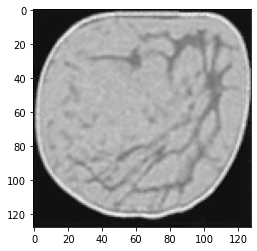

In [20]:
x=114
test = model.predict(np.expand_dims(X_test[x], axis=0))
plt.imshow(test.squeeze(), cmap='gray')
# plt.imsave("../3_pred.jpg", test.squeeze(), cmap='gray')

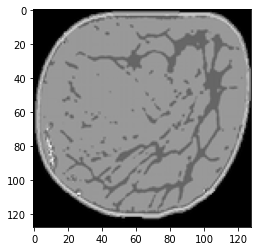

In [21]:
plt.imshow(y_test[x].squeeze(), cmap='gray')
# plt.imsave("../3_gt.jpg", y_test[x].squeeze(), cmap='gray')

dtype('float32')

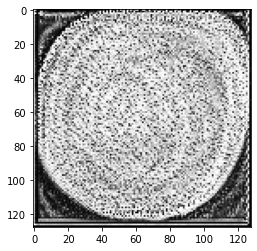

In [22]:
layer_outputs = model.layers[8].output
layer_input = model.layers[0].input
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)
test = feature_map_model.predict(np.expand_dims(X_test[x], axis=0))
plt.imshow(test.squeeze(), cmap='gray')
# plt.imsave("../3_pred.jpg", test.squeeze(), cmap='gray')
test.dtype

In [23]:
model.layers

In [24]:
# model.save_weights("Weights/Automap_breast_150_epochs.hdf5")

##  Import best model and test

In [25]:
model.save("Checkpoints/automap_final_FDPA_LSTM_150_final_unkown")

2022-08-26 20:52:27.580671: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Checkpoints/automap_final_FDPA_LSTM_150_final_unkown/assets


In [26]:
# sio.savemat("test_mat_300fov.mat", dict(inp=X_test[x], gt=y_test[x]))

: 